# Training the model

Catboost was selected as go-to solution for simplicity and ease of implementation

In [1]:
print('Kernel Operational')

Kernel Operational


## Preliminary stage - preparation

### Importing libraries

In [10]:
# Working with data
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Feature engineering
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Additional tools
import time
import os
from dotenv import load_dotenv
from datetime import datetime
import ipywidgets

In [ ]:
# Models
from catboost import CatBoostClassifier

### Loading (and uploading) data

In [11]:
# Loading variables from .env file (you should have one added to .gitignore)
load_dotenv()

# Get database connection params from environment variables
database = os.getenv("DATABASE")
user = os.getenv("USER")
password = os.getenv("PASSWORD")
host = os.getenv("HOST")
port = os.getenv("PORT")

# Form the connection string
connection = f"postgresql://{user}:{password}@{host}:{port}/{database}"

In [12]:
# Acquiring user for training the model
user_data = pd.read_sql(
    """SELECT * 
       FROM public.user_data;
    """,
    con=connection
)

# Checking out the sample
user_data.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


Let's further **enrich the user-level data** somewhat - by making some additional calculations. Not too many - just a "starters" kit.

In [13]:
# Enirching the data somewhat
additional_user_features = pd.read_sql(
    """SELECT user_id,
              COUNT(DISTINCT(post_id)) AS unique_post_interactions,
              COUNT(DISTINCT(post_id)) FILTER (WHERE action ='like') AS posts_liked,
              COUNT(action) FILTER (WHERE action = 'view') AS total_views
       FROM public.feed_data
       GROUP BY user_id
    """,
    con=connection
)

# Checking out the sample
additional_user_features.head()

,user_id,unique_post_interactions,posts_liked,total_views
0,200,346,43,358
1,201,646,58,690
2,202,593,87,637
3,203,311,61,321
4,204,134,23,138


In [14]:
# Adding new features to the general user data table
user_data = user_data.merge(additional_user_features, on='user_id', how='left')
user_data['posts_liked_share'] = user_data['posts_liked'] / user_data['unique_post_interactions']
user_data.sample(5) # Once again - a sample just to check

,user_id,gender,age,country,city,exp_group,os,source,unique_post_interactions,posts_liked,total_views,posts_liked_share
44956,48483,0,21,Russia,Nizhnekamsk,3,Android,ads,243,24,248,0.098765
24295,24509,1,53,Russia,Yakutsk,0,Android,ads,288,24,297,0.083333
130759,136089,0,16,Russia,Tyumen,3,Android,organic,245,9,256,0.036735
50731,54425,0,17,Russia,Pskov,0,iOS,ads,161,18,162,0.111801
95216,99438,1,51,Russia,Volgodonsk,1,Android,ads,519,38,547,0.073218


Let's move over to posts data

In [15]:
# Acquiring post data for training the model
post_data = pd.read_sql(
    """SELECT * 
       FROM public.post_text_df;
    """,
    con=connection
)

# Checking out the sample
post_data.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


Once again - let's enrich it a bit

In [16]:
# Add post length to data about it
post_data['post_length'] = post_data['text'].apply(len) # Calculate the post length

Ideally, **we should aggregate the data in the `feed_data` table within SQL**, so that we could get maximum information from it. However, we're not going to do that now, as it would take a lot of effort and **we might end up with acceptable model even without it.**

As a quick makeshift solution - we will simply limit the number of loaded feed logs - for now, the limit will be set at 4 mil.

Additionally, as the DB states, the `target` is skipped for `action='like'` objects. It means that this column is useless for prediction purposes (on its own).

In [17]:
# Acquiring feed data for training the model - a lot of data, so un-aggregated load would probably result in an error
feed_data = pd.read_sql(
    """SELECT timestamp, user_id, post_id, target
       FROM public.feed_data
       WHERE action = 'view'
       LIMIT 4000000
    """,
    con=connection
)

# Checking out the sample
feed_data.head()

,timestamp,user_id,post_id,target
0,2021-12-05 12:37:52,126238,502,0
1,2021-12-05 12:40:08,126238,1008,0
2,2021-12-05 12:41:50,126238,1103,0
3,2021-12-05 12:44:26,126238,200,0
4,2021-12-05 12:46:34,126238,995,0


### Merging data
Ideally, this would be done on the SQL level - not on the model level. However, for this specific task - we'll do it here.

In [18]:
# Merging
data_total = feed_data.merge(user_data, how='left', on='user_id')
data_total = data_total.merge(post_data, how='left', on='post_id')

# Sample
data_total.sample(5)

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,unique_post_interactions,posts_liked,total_views,posts_liked_share,text,topic,post_length
452869,2021-12-05 06:27:04,133317,81,0,0,20,Russia,Aleksandrovsk-Sakhalinskiy,0,Android,organic,544,44,573,0.080882,JP Morgan admits US slavery links\n\nThousands...,business,1451
3788425,2021-10-16 17:11:52,160078,4391,0,1,44,Russia,Sterlitamak,0,Android,organic,655,56,698,0.085496,"A good film with--for its time--an intense, sp...",movie,937
180051,2021-11-28 21:12:57,126289,6999,1,1,38,Russia,Omsk,4,iOS,organic,366,35,378,0.095628,Mikio Naruses examination of the lives of thre...,movie,2137
2423310,2021-10-28 13:10:22,49685,1012,0,0,29,Russia,Bryansk,2,Android,ads,380,75,398,0.197368,Debate needed on donations cap\n\nA cap on don...,politics,2993
1324339,2021-11-08 11:52:10,133526,6337,0,0,15,Russia,Gusev,3,iOS,organic,173,16,178,0.092486,Sally and Saint Anne is a very funny movie. Th...,movie,750


## EDA
General data analysis stage. Let's take a look at the data distribution - in their relation to the target.

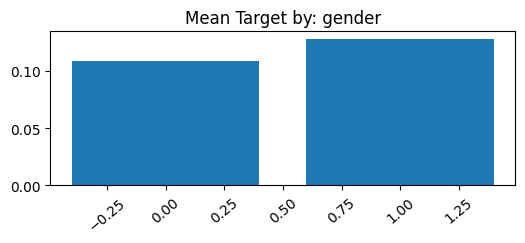

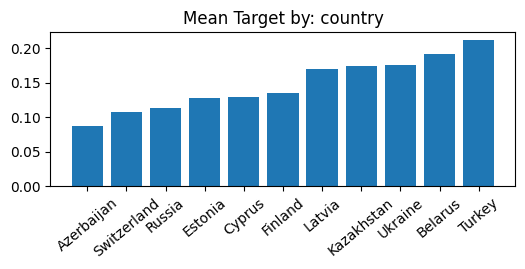

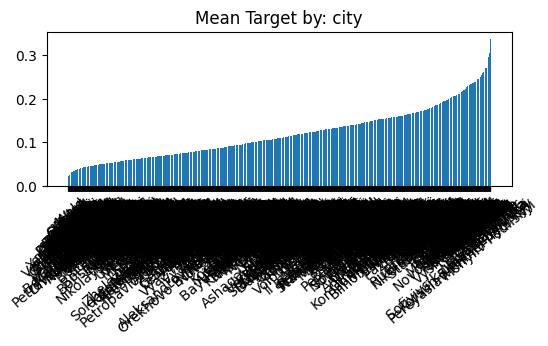

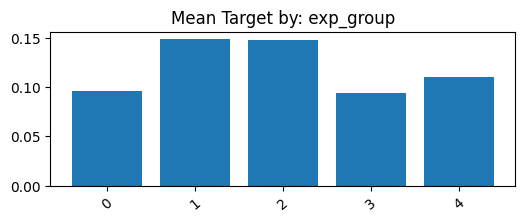

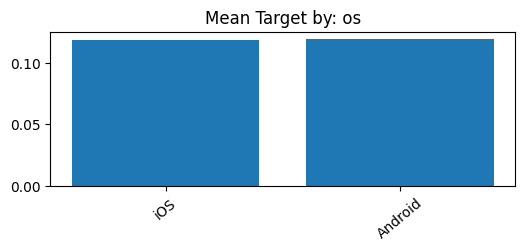

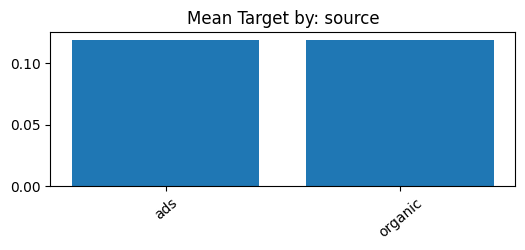

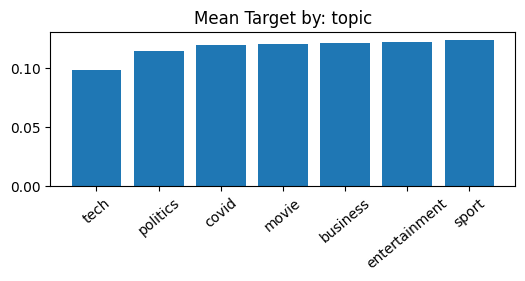

In [19]:
### Mean target by main categorical variables
categorical_variables = ['gender', 'country', 'city', 'exp_group', 'os', 'source', 'topic']

for col in categorical_variables:
    target_table = data_total.groupby(col)['target'].mean()
    target_table = target_table.sort_values()

    fig = plt.figure()
    fig.set_size_inches(6, 2)

    plt.bar(target_table.index, target_table)
    plt.title(f'Mean Target by: {col}')
    plt.xticks(rotation=40)

    plt.show()

**What conclusions can we infer from this data?**
1. There are substantial differences in most categorical variables - substantial enough to leave them and use in further analysis.
2. `OS` and `Source` are the exceptions - no significant differences can be seen.
3. Basic features enough are, most likely, not enough for good predictions. 

Let's **perform some additional transformations**:

First of all - let's begin with time variables. Let's get the `year`, `month`, `weekday` and `hour` variables

In [20]:
# Deriving the variables
data_total['year'] = data_total['timestamp'].dt.year
data_total['month'] = data_total['timestamp'].dt.month
data_total['day'] = data_total['timestamp'].dt.day
data_total['weekday'] = data_total['timestamp'].dt.weekday
data_total['hour'] = data_total['timestamp'].dt.hour

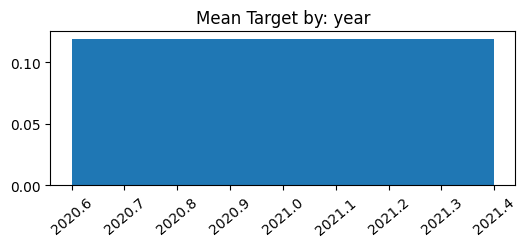

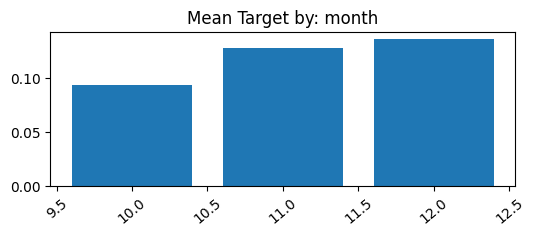

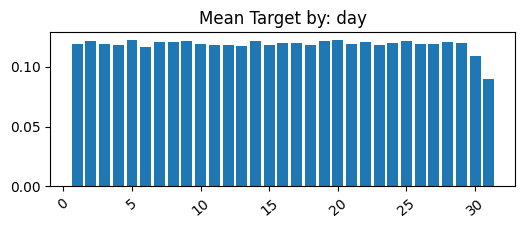

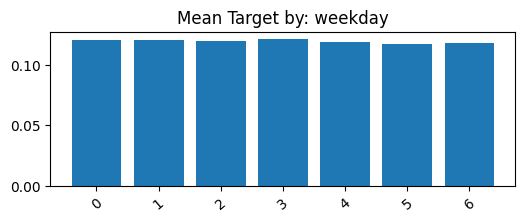

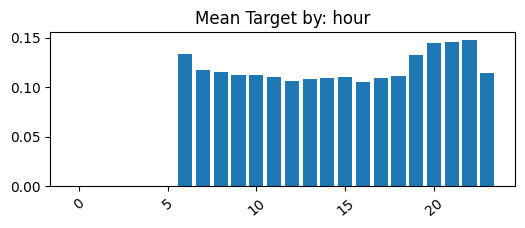

In [21]:
# Visualize these columns:
time_variables = ['year', 'month', 'day', 'weekday', 'hour']

for col in time_variables:
    target_table = data_total.groupby(col)['target'].mean()
    target_table = target_table.sort_values()

    fig = plt.figure()
    fig.set_size_inches(6, 2)

    plt.bar(target_table.index, target_table)
    plt.title(f'Mean Target by: {col}')
    plt.xticks(rotation=40)

    plt.show()

We can see some differences withing time variables. However, something weird happens with `year` and `month`. Let's take a closer look:

In [22]:
# Value counts
data_total['year'].value_counts()

year
2021    4000000
Name: count, dtype: int64

In [23]:
# Value counts
data_total['month'].value_counts()

month
10    1368725
11    1346055
12    1285220
Name: count, dtype: int64

As we can see, there are only events from 2021 present. The `year` variable3 itself could be useful for research and modeling later on (when more data is available), but as of right now - it is useless.

Let's drop it.

In [24]:
# Dropping the year 
data_total = data_total.drop('year', axis=1)

Let's look at numerical variables next

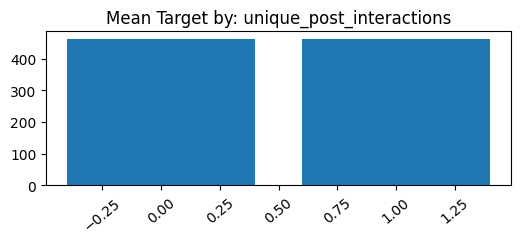

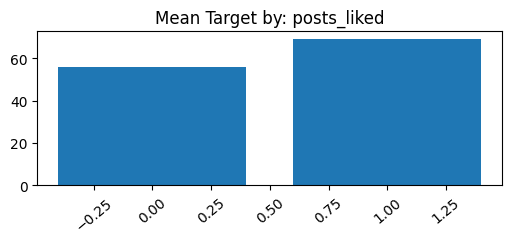

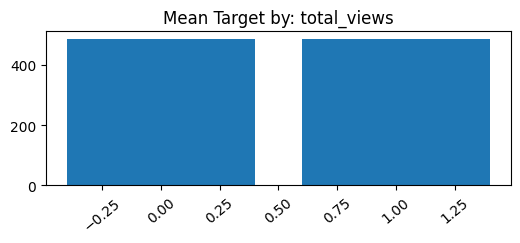

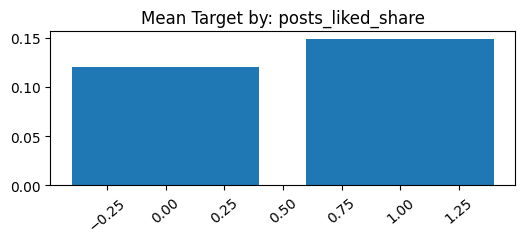

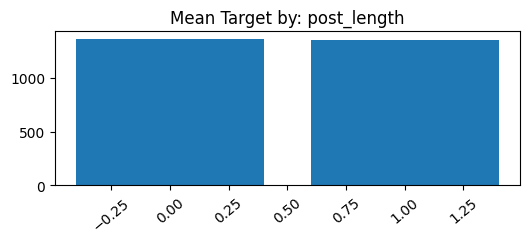

In [25]:
### Mean target by main categorical variables
numerical_variables = ['unique_post_interactions', 'posts_liked', 'total_views', 'posts_liked_share', 'post_length']

for col in numerical_variables:
    target_table = data_total.groupby('target')[col].mean()
    target_table = target_table.sort_values()

    fig = plt.figure()
    fig.set_size_inches(6, 2)

    plt.bar(target_table.index, target_table)
    plt.title(f'Mean Target by: {col}')
    plt.xticks(rotation=40)

    plt.show()

There is still a lot that can be done with that model - categorical variables (including the `exp_group` can and should be encoded) and there is whole array of possible ways to interact with the `text` column - NLP awaits.

However, for now, let's establish a simple baseline - train the CatBoost model on the data as it requires the least prep-work.
- Once it's done - we will optimize the data further and prepare other models - to compare their effectiveness and choose the best one.

## Baseline modeling - CatBoost

First of all - let's split and prepare the data. Let's also ignore the text column - for now.

In [22]:
# What are we working with at this point
data_total.sample(5)

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,...,posts_liked,total_views,posts_liked_share,text,topic,post_length,month,day,weekday,hour
2885142,2021-10-03 16:21:10,86650,1754,0,1,23,Russia,Moscow,2,Android,...,24,170,0.142857,Tottenham bid &#163;8m for Forest duo\n\nNotti...,sport,721,10,3,6,16
100487,2021-12-10 16:46:20,78554,5513,1,1,14,Russia,Murmansk,2,Android,...,105,649,0.173841,This movie was well done in all respects. The ...,movie,262,12,10,4,16
705208,2021-12-01 21:18:20,27317,1731,0,0,28,Russia,Prokhladnyy,4,Android,...,53,617,0.093972,Greek sprinters suspended by IAAF\n\nGreek spr...,sport,1568,12,1,2,21
2864374,2021-12-19 19:23:27,663,4184,0,0,23,Russia,Klimovsk,1,Android,...,40,527,0.078740,Whos to blame? Can we dismiss it as a Covid-19...,covid,136,12,19,6,19
2739069,2021-10-27 07:23:47,142002,3759,0,0,23,Russia,Bol’shiye Klyuchi,3,iOS,...,77,621,0.131175,Please include #S3599 in your next #Covid19 re...,covid,126,10,27,2,7


In [23]:
# Info about the dataset at this point
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000000 entries, 0 to 3999999
Data columns (total 22 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   timestamp                 datetime64[ns]
 1   user_id                   int64         
 2   post_id                   int64         
 3   target                    int64         
 4   gender                    int64         
 5   age                       int64         
 6   country                   object        
 7   city                      object        
 8   exp_group                 int64         
 9   os                        object        
 10  source                    object        
 11  unique_post_interactions  int64         
 12  posts_liked               int64         
 13  total_views               int64         
 14  posts_liked_share         float64       
 15  text                      object        
 16  topic                     object        
 17  post_len

In [24]:
# Getting the copy with needed data
X = data_total.drop(['timestamp', 'target', 'user_id', 'post_id'], axis=1).copy()
y = data_total['target'].copy()

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    stratify=y)

In [20]:
# Columns to process
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200000 entries, 1851685 to 140220
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   gender                    int64  
 1   age                       int64  
 2   country                   object 
 3   city                      object 
 4   exp_group                 int64  
 5   os                        object 
 6   source                    object 
 7   unique_post_interactions  int64  
 8   posts_liked               int64  
 9   total_views               int64  
 10  posts_liked_share         float64
 11  text                      object 
 12  topic                     object 
 13  post_length               int64  
 14  month                     int64  
 15  day                       int64  
 16  weekday                   int64  
 17  hour                      int64  
dtypes: float64(1), int64(11), object(6)
memory usage: 463.9+ MB


In [29]:
# Fitting and training the baseline model
cat_features = ['gender', 'country', 'city', 'exp_group', 'os', 'source', 'topic', 'weekday']
text_features = ['text']

# Preparing and fitting the model
catboost_model = CatBoostClassifier(eval_metric='AUC')
catboost_model.fit(X_train, y_train,
                   cat_features=cat_features,
                   text_features=text_features,
                   eval_set=[(X_test, y_test)],
                   use_best_model=True,
                   verbose=100,
                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.232638
0:	test: 0.6342269	best: 0.6342269 (0)	total: 38.9s	remaining: 10h 48m 30s
100:	test: 0.6910616	best: 0.6910616 (100)	total: 11m 17s	remaining: 1h 40m 29s
200:	test: 0.6997720	best: 0.6997720 (200)	total: 19m 11s	remaining: 1h 16m 17s
300:	test: 0.7045266	best: 0.7045266 (300)	total: 27m 30s	remaining: 1h 3m 54s
400:	test: 0.7068068	best: 0.7068068 (400)	total: 35m 40s	remaining: 53m 16s
500:	test: 0.7083784	best: 0.7083784 (500)	total: 43m 38s	remaining: 43m 27s
600:	test: 0.7096210	best: 0.7096279 (598)	total: 51m 27s	remaining: 34m 9s
700:	test: 0.7103100	best: 0.7103305 (697)	total: 59m 23s	remaining: 25m 19s
800:	test: 0.7109084	best: 0.7109250 (788)	total: 1h 7m 41s	remaining: 16m 49s
900:	test: 0.7113567	best: 0.7113567 (900)	total: 1h 15m 47s	remaining: 8m 19s
999:	test: 0.7115408	best: 0.7115408 (999)	total: 1h 23m 45s	remaining: 0us

bestTest = 0.7115408017
bestIteration = 999



Let's calculate the `hitrate@5` metric for this model:
- NOTE: The required value of this metric is 0.52

In [31]:
# Calculating the metric in question
def calculate_metric(model, df_features, df_targets, global_df=data_total):
    # Preparing metric DF
    ## Making predictions - in probabilities:
    results = model.predict_proba(df_features)[:,1]

    ## Creating a dataset with all neccessary values
    resulting_metric_df = df_features.copy()
    resulting_metric_df['pred'] = results
    resulting_metric_df['target'] = df_targets

    ## Merging data on user and post_ids
    resulting_metric_df = resulting_metric_df.join(global_df[['user_id', 'post_id']])

    ## Dropping unneccessary columns:
    resulting_metric_df = resulting_metric_df[['user_id', 'post_id', 'target', 'pred']]

    # Metric calculation
    ## Step 1: Group by user_id and for each user, get the top 5 post_ids by pred
    top_5_posts_per_user = (resulting_metric_df.groupby('user_id').apply(
        lambda x: x.nlargest(5, 'pred')).reset_index(drop=True)  # Get top 5 rows by pred for each user
    )
    
    ## Step 2: For each group of top 5 posts, check if any of the target values is 1
    user_metric = top_5_posts_per_user.groupby('user_id')['target'].apply(
        lambda x: 1 if x.eq(1).any() else 0
    )
    
    ## Step 3: Calculate the final metric as the mean of the user metrics
    final_metric = user_metric.mean()
    
    return final_metric

In [32]:
# Let's calculate the metric for the current dataset
final_metric = calculate_metric(catboost_model, X_test, y_test)
print(f"Final Metric: {final_metric}")

Final Metric: 0.6769019731982695


An amazing result - the baseline catboost model without any additional tuning or text pre-processing trained on limited data provided already provides us with the required metric value. Let's try working with that model.

In [33]:
# Saving the model
catboost_model.save_model('catboost_model',
                           format="cbm")

## Data Uploading

Let's load the user-level data into a separate DB - as the task requires.

First of all - we need to prepare it. Luckily, we have already loaded that data into the `user_data` dataframe.

In [ ]:
# Dropping the already existing table
pd.read_sql(
    """ DROP TABLE recommendation_service_features
    """,
    con=connection
)

In [27]:
# Specify data types
user_data['user_id'] = user_data['user_id'].astype(int)  # int64
user_data['gender'] = user_data['gender'].astype(int)  # int64
user_data['age'] = user_data['age'].astype(int)  # int64
user_data['country'] = user_data['country'].astype(str)  # varchar
user_data['city'] = user_data['city'].astype(str)  # varchar
user_data['exp_group'] = user_data['exp_group'].astype(int)  # int64
user_data['os'] = user_data['os'].astype(str)  # varchar
user_data['source'] = user_data['source'].astype(str)  # varchar
user_data['unique_post_interactions'] = user_data['unique_post_interactions'].astype(int)  # int64
user_data['posts_liked'] = user_data['posts_liked'].astype(int)  # int64
user_data['total_views'] = user_data['total_views'].astype(int)  # int64
user_data['posts_liked_share'] = user_data['posts_liked_share'].astype(float)  # float

# Reorder data
upload_user_data = user_data[['user_id', 'gender', 'age', 'country', 'city', 'exp_group', 'os', 'source', 'unique_post_interactions', 'posts_liked', 'total_views', 'posts_liked_share']]

# Sample
upload_user_data.sample(3)

,user_id,gender,age,country,city,exp_group,os,source,unique_post_interactions,posts_liked,total_views,posts_liked_share
126685,132015,0,15,Russia,Sharan,4,Android,organic,260,15,271,0.057692
19835,20046,1,27,Russia,Moscow,4,Android,ads,668,105,708,0.157186
16879,17089,1,23,Russia,Makhachkala,0,Android,ads,354,39,360,0.110169


In [28]:
# Creating engine
engine = create_engine(connection)

# Loading data unto the server with retries
def load_data_with_retries(df, table_name, chunk_size=1000, retries=100, delay=1):
    total_chunks = len(df) // chunk_size + (1 if len(df) % chunk_size > 0 else 0)
    
    for chunk_index in range(total_chunks):
        chunk = df.iloc[chunk_index * chunk_size:(chunk_index + 1) * chunk_size]
        
        for attempt in range(retries):
            try:
                chunk.to_sql(table_name, con=engine, if_exists='append', index=False)
                print(f"Part {chunk_index + 1}/{total_chunks} loaded successfully.")
                break  # If attempt is successful - exit the cycle
            except Exception as e:
                print(f"Error when loading part {chunk_index + 1}: {e}")
                if attempt < retries - 1:  # Not the last try
                    print(f"Re-attempting to load part {chunk_index + 1} after {delay} seconds...")
                    time.sleep(delay)  # Waiting before trying again
                else:
                    print(f"All attempts to load part {chunk_index + 1} have failed.")
                    break  # If all attempts failed - stop data upload

# Загрузка данных
load_data_with_retries(upload_user_data, 'recommendation_service_features')

Part 1/164 loaded successfully.
Part 2/164 loaded successfully.
Part 3/164 loaded successfully.
Part 4/164 loaded successfully.
Part 5/164 loaded successfully.
Part 6/164 loaded successfully.
Part 7/164 loaded successfully.
Part 8/164 loaded successfully.
Part 9/164 loaded successfully.
Part 10/164 loaded successfully.
Part 11/164 loaded successfully.
Part 12/164 loaded successfully.
Part 13/164 loaded successfully.
Part 14/164 loaded successfully.
Part 15/164 loaded successfully.
Part 16/164 loaded successfully.
Part 17/164 loaded successfully.
Part 18/164 loaded successfully.
Part 19/164 loaded successfully.
Part 20/164 loaded successfully.
Part 21/164 loaded successfully.
Part 22/164 loaded successfully.
Part 23/164 loaded successfully.
Part 24/164 loaded successfully.
Part 25/164 loaded successfully.
Part 26/164 loaded successfully.
Part 27/164 loaded successfully.
Part 28/164 loaded successfully.
Part 29/164 loaded successfully.
Part 30/164 loaded successfully.
Part 31/164 loaded 

In [41]:
X_train.sample(2)

,gender,age,country,city,exp_group,os,source,unique_post_interactions,posts_liked,total_views,posts_liked_share,text,topic,post_length,month,day,weekday,hour
2268327,1,28,Russia,Novoaltaysk,0,Android,ads,520,47,549,0.090385,New yob targets to be unveiled\n\nFifty new ar...,politics,2443,11,29,0,12
3767887,0,15,Russia,Izhevsk,0,Android,ads,585,35,628,0.059829,"/WATCH/READ/ #Medical #tech, #healthcare #star...",covid,136,10,12,1,6


## Basic testing

Let's check out the results - see if everything works as intended

In [61]:
# Select proper user
user_data_curr = user_data[user_data['user_id'] == 149436]

# Concatenating user_data info to every post
post_data['gender'] = user_data_curr.iloc[0]['gender']
post_data['age'] = user_data_curr.iloc[0]['age']
post_data['country'] = user_data_curr.iloc[0]['country']
post_data['city'] = user_data_curr.iloc[0]['city']
post_data['exp_group'] = user_data_curr.iloc[0]['exp_group']
post_data['os'] = user_data_curr.iloc[0]['os']
post_data['source'] = user_data_curr.iloc[0]['source']
post_data['unique_post_interactions'] = user_data_curr.iloc[0]['unique_post_interactions']
post_data['posts_liked'] = user_data_curr.iloc[0]['posts_liked']
post_data['total_views'] = user_data_curr.iloc[0]['total_views']
post_data['posts_liked_share'] = user_data_curr.iloc[0]['posts_liked_share']

# Time data
post_data['month'] = datetime.now().month
post_data['day'] = datetime.now().day
post_data['weekday'] = datetime.now().weekday()
post_data['hour'] = datetime.now().hour


# Leave the variables that matter
curr_post_data = post_data[['gender', 'age', 'country', 'city', 'exp_group', 'os', 'source', 'unique_post_interactions', 'posts_liked', 'total_views', 'posts_liked_share', # user-level data
                            'text', 'topic', 'post_length', 'month', 'day', 'weekday', 'hour']] # post-level data

# Make a prediction
curr_post_data['pred'] = catboost_model.predict_proba(curr_post_data)[:,1]

# Top-n predictions
top_idx = curr_post_data.sort_values(by='pred', ascending=False).head(5).index
top_posts = post_data.iloc[top_idx][['post_id', 'text', 'topic']]

In [75]:
# Alternative
# Select the user data just once
user_data_curr = user_data[user_data['user_id'] == 149436].iloc[0]

# Concatenating user_data info to every post at once by using a dictionary
user_info = {
    'gender': user_data_curr['gender'],
    'age': user_data_curr['age'],
    'country': user_data_curr['country'],
    'city': user_data_curr['city'],
    'exp_group': user_data_curr['exp_group'],
    'os': user_data_curr['os'],
    'source': user_data_curr['source'],
    'unique_post_interactions': user_data_curr['unique_post_interactions'],
    'posts_liked': user_data_curr['posts_liked'],
    'total_views': user_data_curr['total_views'],
    'posts_liked_share': user_data_curr['posts_liked_share']
}

# Update post_data in one step
post_data = post_data.assign(**user_info)

# Time data - only call datetime.now() once
now = datetime.now()
post_data['month'] = now.month
post_data['day'] = now.day
post_data['weekday'] = now.weekday()
post_data['hour'] = now.hour

# Leave the variables that matter
features = ['gender', 'age', 'country', 'city', 'exp_group', 'os', 'source', 'unique_post_interactions', 
            'posts_liked', 'total_views', 'posts_liked_share', 'text', 'topic', 'post_length', 'month', 'day', 
            'weekday', 'hour']
curr_post_data = post_data[features]

# Make a prediction
curr_post_data['pred'] = catboost_model.predict_proba(curr_post_data)[:, 1]

# Get the top 5 predictions (by indices)
top_idx = curr_post_data.nlargest(5, 'pred').index

# Retrieve 'post_id', 'text', and 'topic' from the original post_data using top_idx
top_posts = post_data.loc[top_idx, ['post_id', 'text', 'topic']]

In [68]:
# Let's see the recommendations
for post in top_posts:
    print(post)

2646
1284
918
2540
1154


In [58]:
user_data.sample(3)

,user_id,gender,age,country,city,exp_group,os,source,unique_post_interactions,posts_liked,total_views,posts_liked_share
130361,135691,0,29,Russia,Saint Petersburg,3,Android,organic,533,71,576,0.133208
134870,140201,1,38,Russia,Rezh,0,Android,organic,333,19,346,0.057057
144100,149436,1,23,Azerbaijan,Baku,3,Android,organic,469,25,479,0.053305
